In [1]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

In [2]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [4]:
import deeptime
deeptime.__version__

'0.4.4'

In [5]:
class Dimer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "CD":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "OD":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "DC":
            return np.asarray([0.1, 0.4, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "DO":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "DD":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.4, 0.6])
            
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC","OC","CO", "OO", "CD", "OD", "DC", "DO", "DD"]
    
    single_states = ["C", "O", "D"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_CO", "CC_OO", "CC_CD", "CC_OD", "CC_DC", "CC_DO", "CC_DD"],
                      ["OC_CC", "OC_OC", "OC_CO", "OC_OO", "OC_CD", "OC_OD", "OC_DC", "OC_DO", "OC_DD"],
                      ["CO_CC", "CO_OC", "CO_CO", "CO_OO", "CO_CD", "CO_OD", "CO_DC", "CO_DO", "CO_DD"],
                      ["OO_CC", "OO_OC", "OO_CO", "OO_OO", "OO_CD", "OO_OD", "OO_DC", "OO_DO", "OO_DD"],
                      ["CD_CC", "CD_OC", "CD_CO", "CD_OO", "CD_CD", "CD_OD", "CD_DC", "CD_DO", "CD_DD"],
                      ["OD_CC", "OD_OC", "OD_CO", "OD_OO", "OD_CD", "OD_OD", "OD_DC", "OD_DO", "OD_DD"],
                      ["DC_CC", "DC_OC", "DC_CO", "DC_OO", "DC_CD", "DC_OD", "DC_DC", "DC_DO", "DC_DD"],
                      ["DO_CC", "DO_OC", "DO_CO", "DO_OO", "DO_CD", "DO_OD", "DO_DC", "DO_DO", "DO_DD"],
                      ["DD_CC", "DD_OC", "DD_CO", "DD_OO", "DD_CD", "DD_OD", "DD_DC", "DD_DO", "DD_DD"],
                     ]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  #CC
                        [0.1, 0.3, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #OC
                        [0.1, 0.0, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #CO
                        [0.0, 0.1, 0.1, 0.4, 0.0, 0.2, 0.0, 0.2, 0.0],  #OO
                        [0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.0, 0.0, 0.4],  #CD
                        [0.0, 0.3, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0, 0.2],  #OD
                        [0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.4],  #DC
                        [0.0, 0.0, 0.3, 0.1, 0.0, 0.0, 0.2, 0.2, 0.2],  #DO
                        [0.0, 0.0, 0.0, 0.0, 0.15, 0.1, 0.15, 0.1, 0.5] #DD
                       ]

In [6]:
glic_dimer = Dimer(0)

In [7]:
glic_dimer.run(50000)

In [8]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [9]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

In [10]:
from deeptime.decomposition import VAMP

tica = VAMP(var_cutoff=0.8, lagtime=5)

tica.fit(dataset)

tica_output= [tica.transform(traj) for traj in dataset.trajectories]
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

In [11]:
from sym_msm.decomposition.sym_tica import SymVAMP_NOAUG

dataset = TrajectoryDataset(5, data[0])

symtica_noaug = SymVAMP_NOAUG(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica_noaug.fit(dataset)

symtica_noaug_output= symtica_noaug.transform(data[0])
symtica_noaug_concatenated= np.concatenate(symtica_noaug_output)

NotImplementedError: SymVAMP_NOAUG is not implemented yet.

In [43]:
from sym_msm.decomposition.sym_tica import SymTICA, SymVAMP

dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

symtica = SymVAMP(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(data[0])
symtica_concatenated= np.concatenate(symtica_output)

<Axes: >

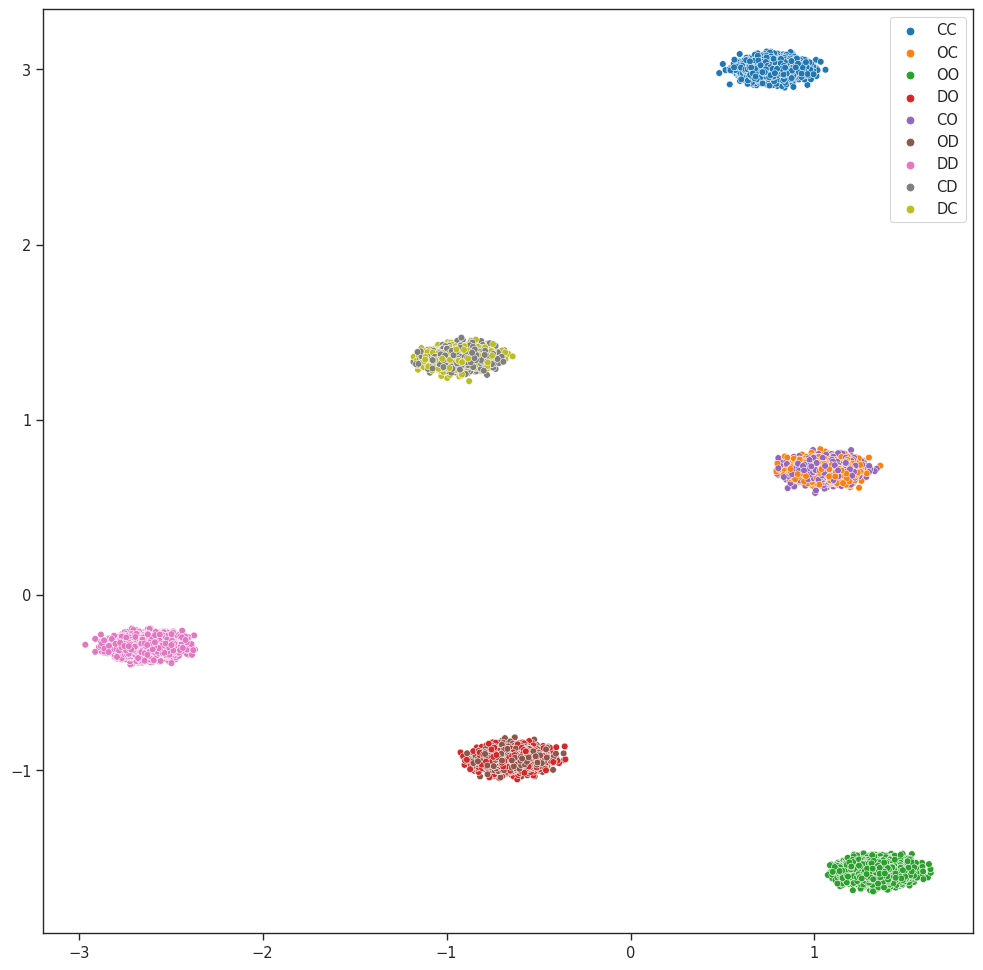

In [30]:
sns.scatterplot(x=symtica_output[:,0],
                y=symtica_output[:,1],
                hue=glic_dimer.trajectory_states)